In [2]:
!pip install torch_geometric
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 67.0 MB/s eta 0:00:00


In [5]:
import os
os.getcwd()

'C:\\Users\\Jiancheng Zhu\\Documents\\Python Scripts\\Kaggle Projects\\AqSolDB\\data'

In [4]:
#Depends on where is raw data is stored.
os.chdir('..')
os.chdir('data')

In [2]:
import deepchem as dc
import pandas as pd
import numpy as np
import os
import math
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import AllChem
from GCN_model import CustomGCN
from custom_dataset import CustomDataset
from trainer import Trainer
import matplotlib.pyplot as plt
import logging
logging.getLogger('deepchem').setLevel(logging.ERROR)

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [6]:
#Load the raw dataset.
df = pd.read_csv('curated-solubility-dataset.csv')

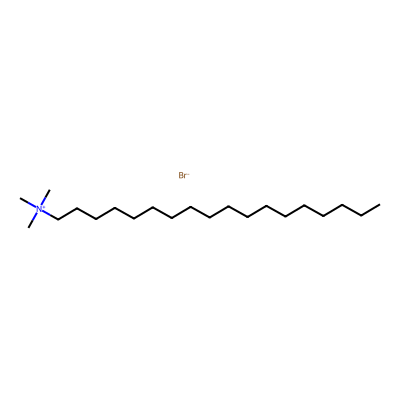

In [7]:
mol = Chem.MolFromSmiles(df.loc[0, 'SMILES'])
options = Draw.MolDrawOptions()
options.atomLabelFontSize = 12
Draw.MolToImage(mol, size = (400, 400), wedgebonds = False, options = options)

In [8]:
max_sol = df['Solubility'].max()
min_sol = df['Solubility'].min()
df['Solubility'].describe()

count    9982.000000
mean       -2.889909
std         2.368154
min       -13.171900
25%        -4.326325
50%        -2.618173
75%        -1.209735
max         2.137682
Name: Solubility, dtype: float64

In [9]:
#View the distribution of LogS using bar chart.
bins = list(range(math.floor(min_sol), math.ceil(max_sol), 2))
df['binned'] = pd.cut(df['Solubility'], bins)
bin_counts = df['binned'].value_counts().sort_index()

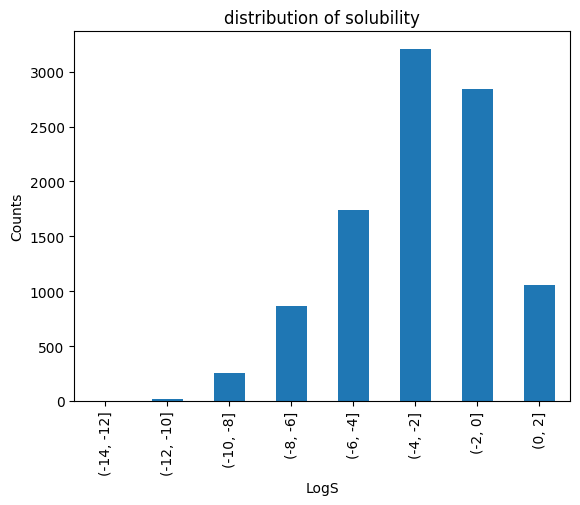

In [10]:
bin_counts.plot(kind = 'bar')
plt.title('distribution of solubility')
plt.xlabel('LogS')
plt.ylabel('Counts')
plt.show()

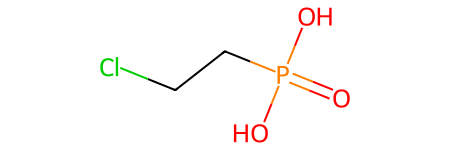

In [12]:
#View the mol w/ LogS > 0.
mol1 = Chem.MolFromSmiles(df[df['Solubility'] > 0]['SMILES'].sample(1).values[0])
mol1

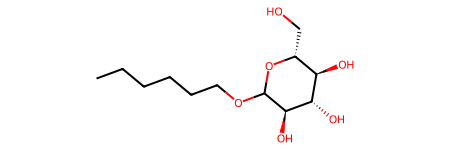

In [13]:
#View the mol w/ -2 < LogS < 0.
mol2 = Chem.MolFromSmiles(df[(0 > df['Solubility'])&(df['Solubility'] > -2)]['SMILES'].sample(1).values[0])
mol2

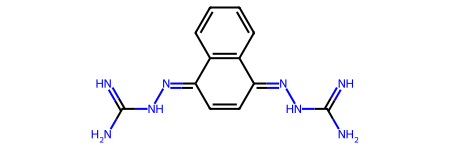

In [14]:
#View the mol w/ -4 < LogS < -2.
mol3 = Chem.MolFromSmiles(df[(-2 > df['Solubility'])&(df['Solubility'] > -4)]['SMILES'].sample(1).values[0])
mol3

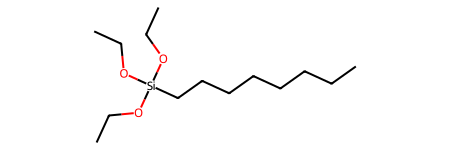

In [15]:
#View the mol w/ -4 > LogS.
mol4 = Chem.MolFromSmiles(df[-4 > df['Solubility']]['SMILES'].sample(1).values[0])
mol4

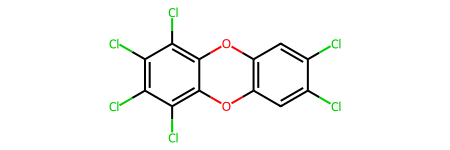

In [16]:
#View the extremly non -soluable mol. 
mol5 = Chem.MolFromSmiles(df[-10 > df['Solubility']]['SMILES'].sample(1).values[0])
mol5

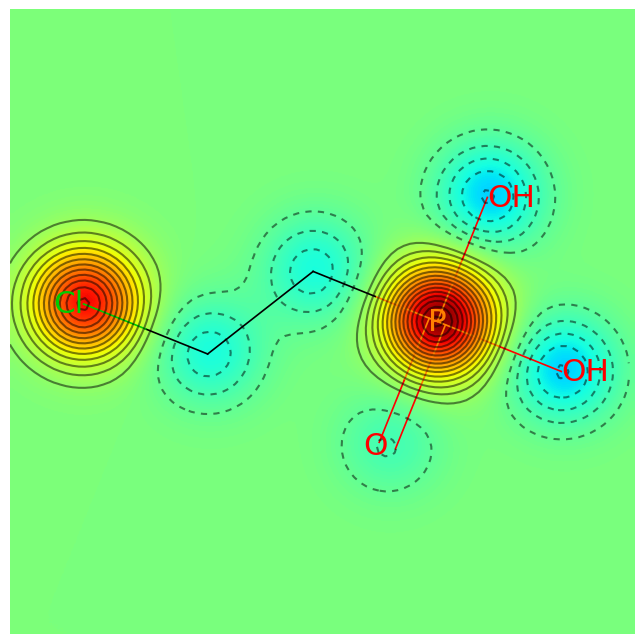

In [17]:
#View the contribution to partition coeff, LogP, between octanol & water.
contributions = rdMolDescriptors._CalcCrippenContribs(mol1)
logP_contribs = [i[0] for i in contributions]
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol1, logP_contribs, colorMap = 'jet', contourLines = 20)

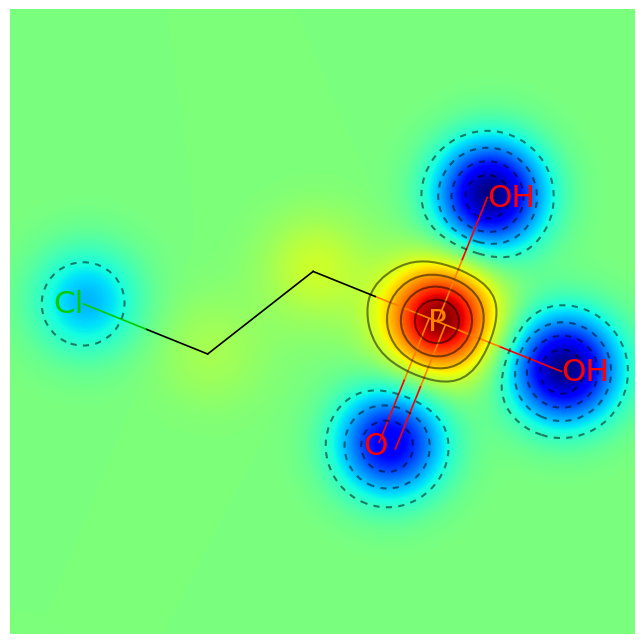

In [18]:
#View charge contribution.
AllChem.ComputeGasteigerCharges(mol1)
contribs = [mol1.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol1.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol1, contribs, colorMap='jet', contourLines=10)

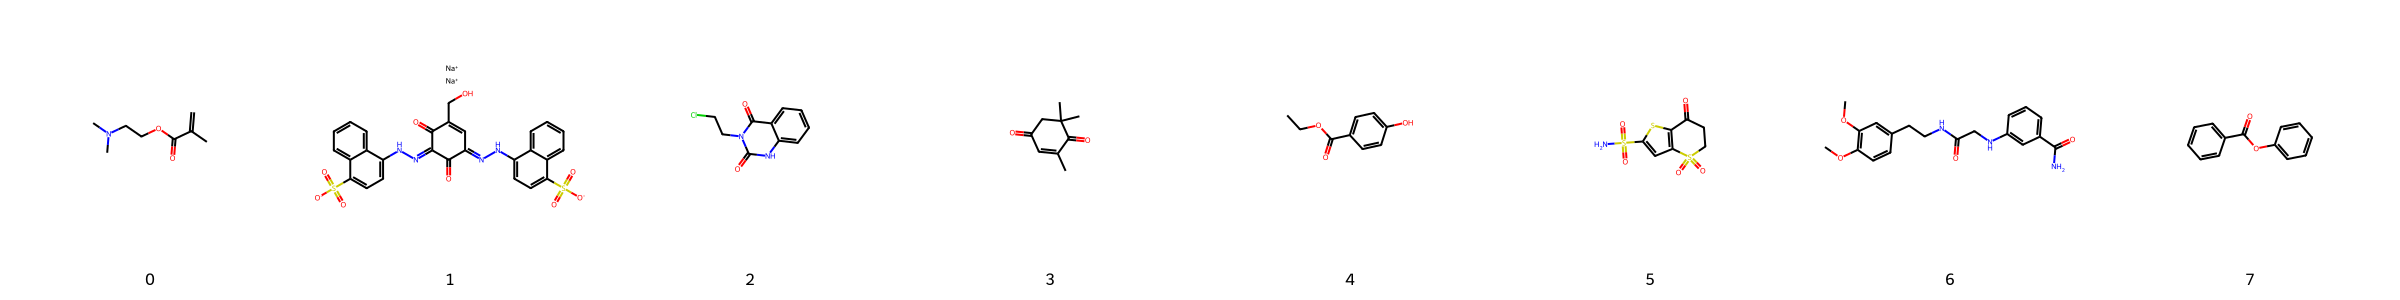

In [20]:
mols = list(Chem.MolFromSmiles(i) for i in df['SMILES'].sample(n = 8))
images = Draw.MolsToGridImage(mols, molsPerRow = 8, subImgSize = (300, 300), legends = [str(i) for i in range(len(mols))])
images

In [28]:
df.columns #column names

Index(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT', 'binned'],
      dtype='object')

In [22]:
os.getcwd()

'C:\\Users\\Jiancheng Zhu\\Documents\\Python Scripts\\Kaggle Projects\\AqSolDB\\data'

In [23]:
root = 'C:\\Users\\Jiancheng Zhu\\Documents\\Python Scripts\\Kaggle Projects\\AqSolDB\\data'
CD = CustomDataset(root)

C:\Anaconda\envs\CHEM\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(f) != _repr(self.p

Processing rows:   0%|          | 0/9982 [00:00<?, ?it/s]

[00:19:10] WARNING: not removing hydrogen atom without neighbors
[00:19:11] WARNING: not removing hydrogen atom without neighbors
[00:19:11] WARNING: not removing hydrogen atom without neighbors
[00:19:12] WARNING: not removing hydrogen atom without neighbors
[00:19:13] WARNING: not removing hydrogen atom without neighbors
[00:19:13] WARNING: not removing hydrogen atom without neighbors
[00:19:14] WARNING: not removing hydrogen atom without neighbors
[00:19:14] WARNING: not removing hydrogen atom without neighbors
[00:19:14] WARNING: not removing hydrogen atom without neighbors
[00:19:14] WARNING: not removing hydrogen atom without neighbors
[00:19:14] WARNING: not removing hydrogen atom without neighbors
[00:19:15] WARNING: not removing hydrogen atom without neighbors
[00:19:23] WARNING: not removing hydrogen atom without neighbors
[00:19:23] WARNING: not removing hydrogen atom without neighbors
[00:19:23] WARNING: not removing hydrogen atom without neighbors
[00:19:23] WARNING: not r

9833 molecules have been processed in file curated-solubility-dataset.csv.


Done!


In [24]:
CD.data.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT,Sol_Label
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334,1
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248,1
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065,1
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666,1
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934,0


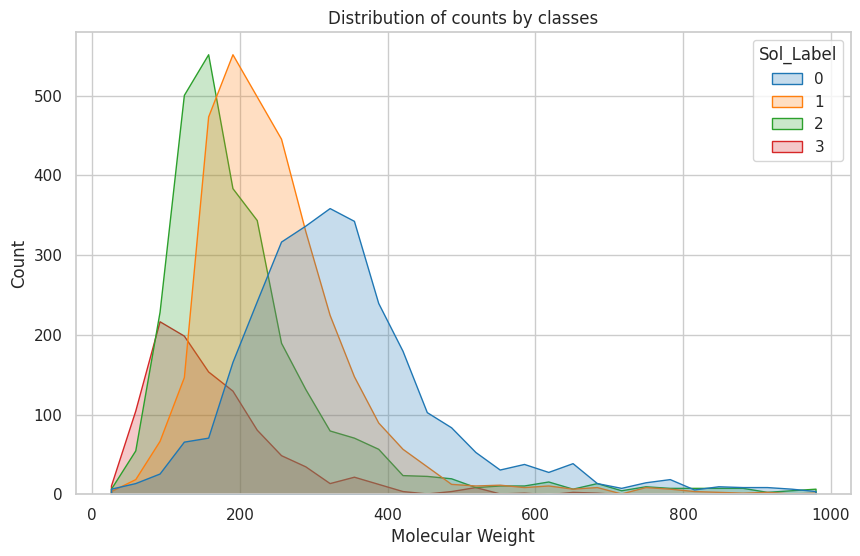

In [33]:
#View the influence of molecular weight to the classification of LogS.
sns.set(style = 'whitegrid')
plt.figure(figsize = (10, 6))
sns.histplot(data = CD.data[CD.data.MolWt<1000], x = 'MolWt', hue = 'Sol_Label', element = 'poly', bins = 30, palette = 'tab10')
plt.title('Distribution of counts by classes')
plt.xlabel('Molecular Weight')
plt.ylabel('Count')
plt.show()

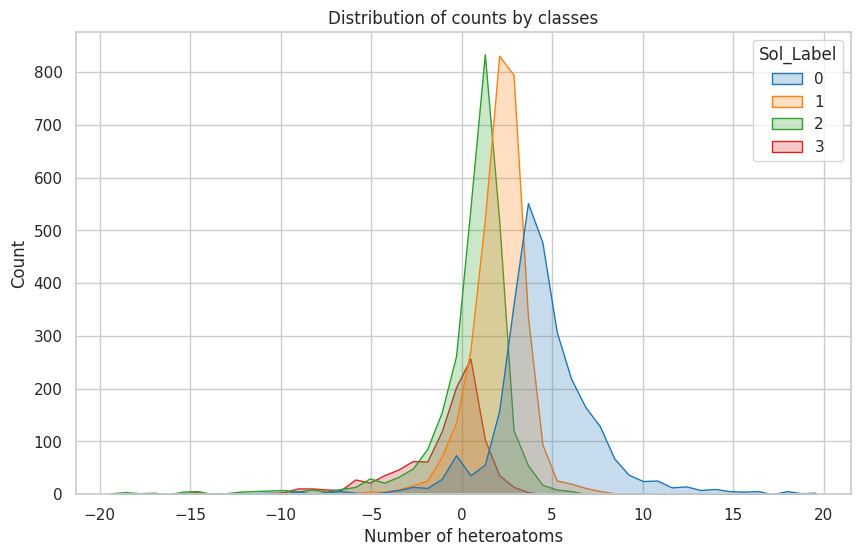

In [34]:
#View the influence of num of heteroatoms to the classification of LogS.
sns.set(style = 'whitegrid')
plt.figure(figsize = (10, 6))
sns.histplot(data = CD.data[(CD.data.MolLogP<20) & (CD.data.MolLogP>-20)], x = 'MolLogP', hue = 'Sol_Label', element = 'poly', bins = 50, palette = 'tab10')
plt.title('Distribution of counts by classes')
plt.xlabel('Number of heteroatoms')
plt.ylabel('Count')
plt.show()

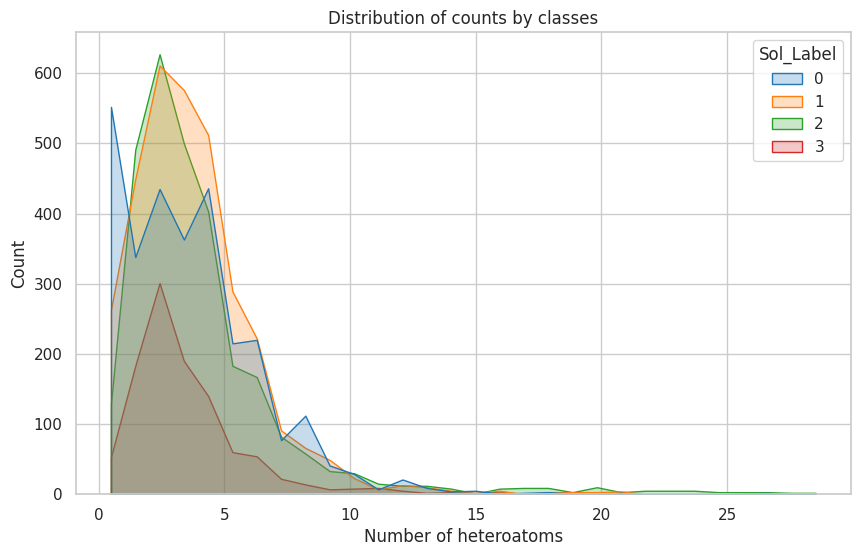

In [35]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (10, 6))
sns.histplot(data = CD.data[CD.data.NumHAcceptors<30], x = 'NumHAcceptors', hue = 'Sol_Label', element = 'poly', bins = 30, palette = 'tab10')
plt.title('Distribution of counts by classes')
plt.xlabel('Number of heteroatoms')
plt.ylabel('Count')
plt.show()

In [36]:
#Done